In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats
import scipy
from functools import reduce
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine, savefig
from spatial_maps.fields import find_peaks, calculate_field_centers, separate_fields_by_laplace
from spike_statistics.core import permutation_resampling_test, block_bootstrap
import speed_cells.speed as spd
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

12:30:57 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "running-speed"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [ ]:
keys_speed = [
    'average_speed',
    'action'
]

colors = ['#1b9e77','#d95f02','#7570b3', '#e7298a']

labels_speed = [
    'Baseline I', 
    '11 Hz',
    'Baseline II', 
    '30 Hz'
]
queries_speed = [
    'baseline and i and Hz11',
    'frequency==11 and stim_location=="ms"', 
    'baseline and ii and Hz30',
    'frequency==30 and stim_location=="ms"']


results_speed = {}

for key in keys_speed:
    results_speed[key] = list()
    for query, label in zip(queries_speed, labels_speed):
        values = data.query(query + f' and {cell_type}').loc[:,['entity', 'date', key]].drop_duplicates(['entity', 'date'])
        results_speed[key].append(values.rename({key: label}, axis=1))
    df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'date'], how='outer'), results_speed[key])
    results_speed[key] = df#.drop('unit_day',axis=1)

In [ ]:
for idx, row in results_speed['action'].loc[:, labels_speed].iterrows():
    for column, action_id in row.dropna().items():
        v = data_loader.tracking(action_id).get('v')
        results_speed['average_speed'].loc[idx, column] = np.nanmean(v)

In [ ]:
(output_path / "data" / "results_speed").mkdir(exist_ok=True, parents=True)

for key, df in results_speed.items():
    df.to_csv(output_path / "data" / "results_speed" / (key + '.csv'))

# speed analysis

In [4]:
results_speed = {}

for path in (output_path / 'data' / 'results_speed').iterdir():
    results_speed[path.stem] = pd.read_csv(path, index_col='Unnamed: 0')

In [5]:
results_speed['average_speed'].groupby('entity').count()

,date,Baseline I,11 Hz,Baseline II,30 Hz
entity,,,,,
1833,8,7,7,5,6
1834,6,6,6,5,5
1839,4,3,4,2,2
1849,6,6,5,4,4


In [10]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')
#     raise
#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return statistic, pvalue, len(dff)


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [11]:
keys_speed = [
    'average_speed',
    'action'
]

colors = ['#1b9e77','#d95f02','#7570b3', '#e7298a']

labels_speed = [
    'Baseline I', 
    '11 Hz',
    'Baseline II', 
    '30 Hz'
]

In [12]:
paired_stat_speed = pd.DataFrame()
for key, df in results_speed.items():
    if key == 'action':
        continue
    if key == 'xcorr_displacement':
        continue
    Key = rename(key)
    labels = df.columns.drop(['entity', 'date']).tolist()

    for label in labels:
        norm = normality(df, label) if df[label].count() >= 8 else np.nan
        paired_stat_speed.loc[f'Normality {label}', Key] = norm
        paired_stat_speed.loc[f'{label}', Key] = f"{df[label].mean():.1e} ± {df[label].sem():.1e}, ({df[label].count()})"

    for i, c1 in enumerate(labels):
        for c2 in labels[i+1:]:
            statistic, pval, n = wilcoxon(df, [c1, c2])
            paired_stat_speed.loc[f'Wilcoxon {c1} - {c2}', Key] = "{:.2f}, {:.1e}, ({})".format(statistic, pval, n)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [13]:
paired_stat_speed

,Average speed
Normality Baseline I,"18.24, 1.1e-04"
Baseline I,"1.6e-01 ± 5.4e-03, (22)"
Normality 11 Hz,"1.41, 4.9e-01"
11 Hz,"1.5e-01 ± 3.9e-03, (22)"
Normality Baseline II,"12.64, 1.8e-03"
Baseline II,"1.5e-01 ± 3.6e-03, (16)"
Normality 30 Hz,"2.88, 2.4e-01"
30 Hz,"1.4e-01 ± 5.3e-03, (17)"
Wilcoxon Baseline I - 11 Hz,"47.00, 1.7e-02, (21)"
Wilcoxon Baseline I - Baseline II,"17.00, 1.5e-02, (15)"


In [14]:
paired_stat_speed.to_latex(output_path / "statistics" / f"paired-statistics_speed.tex")
paired_stat_speed.to_csv(output_path / "statistics" / f"paired-statistics_speed.csv")

In [255]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

def violinplot(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmeans=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6, 1.2, 1.7999999999999998]


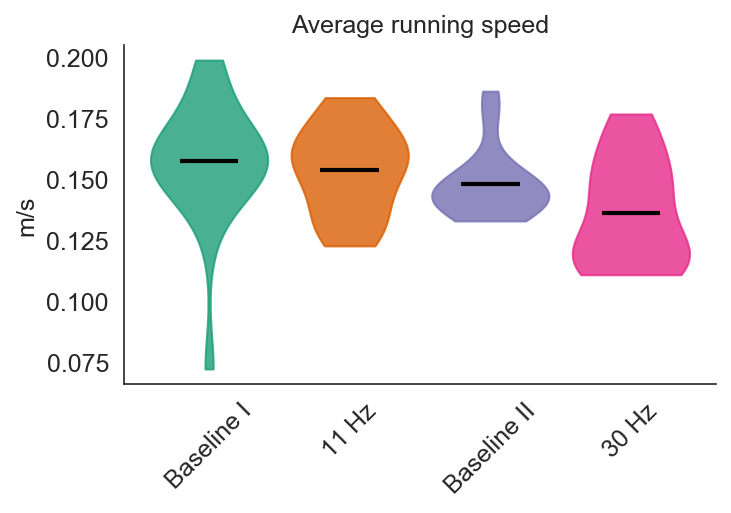

In [256]:
plt.figure()
violinplot([results_speed['average_speed'].loc[:,label].dropna().to_numpy() for label in labels_speed], xticks=labels_speed, colors=colors)
plt.title(f"Average running speed")
plt.ylabel("m/s")
savefig(output_path / 'figures' / 'running_speed')

# Save to expipe

In [50]:
action = project.require_action("running-speed")

In [51]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/PRS.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/summary.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/PRS.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/MWU.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/summary.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/MWU.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_629_rate_map.svg',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_150_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_317_rate_map.png',
 '/media/storage

In [52]:
septum_mec.analysis.registration.store_notebook(action, "20_running_speed.ipynb")